---
title: cheg325 homework7 SIS 13.22
author: kyle wodehouse
date: today
format:
    html:
        self-contained: true
---

Continuing from the hand written portion...

we know

$$
K_a^\circ (T) = \exp \left( \frac{-\Delta_\mathrm{rxn} G^\circ}{RT} \right)
$$

of course we need to use some delightful formation values for the free energy here.

In [1]:
import pandas as pd
import numpy as np
from scipy.constants import R
from scipy.optimize import least_squares
from scipy.integrate import quad


a4 = pd.read_csv('appendix_a4.csv', index_col=1)
a4.head(3)

,chemical_name,state,delta_h_form,delta_g_form
chemical_formula,,,,
CH4,Methane,g,-74.5,-50.5
C2H6,Ethane,g,-83.8,-31.9
C3H8,Propane,g,-104.7,-24.3


remembering the reaction
$$
\mathrm{N_2O_4}  \leftrightharpoons \mathrm{2 NO_2} 
$$

In [2]:
components = ['N2O4', 'NO2']
coeffs = np.array([-1,2])
temp = a4.loc[components]

G = (temp['delta_g_form'].astype(float) * coeffs).sum() * 1000
print(f'∆Gº: {G:.1f}')

K0 = np.exp(-G / R / 298.15)
print(f'Kº: {K0:.3f}')

∆Gº: 4700.0
Kº: 0.150


now our kinda flowsheet is for each value of T we need to 

- calculate the new $K_a$ value 
- use that to find X

then we can graph $C_{v,\mathrm{eff}}$ using numerical techniques

In [3]:
heat_capacity = pd.read_csv('appendix_cp.csv', index_col=1).fillna(0) # table from appendix
heat_capacity = heat_capacity[['a', 'b', 'c', 'd']]

def calcK_andX(T, species=components, coeffs=coeffs):
    cp_data = np.array(heat_capacity.loc[species])
    coeffs = np.array(coeffs)
    
    delta_a, delta_b, delta_c, delta_d = (cp_data * coeffs[:, np.newaxis]).sum(axis=0)
    
    thermo_data = temp
    delta_H = (thermo_data['delta_h_form'].astype(float) * coeffs).sum() * 1000  # J/mol
    delta_G = (thermo_data['delta_g_form'].astype(float) * coeffs).sum() * 1000  # J/mol
    
    K_298 = np.exp(-delta_G / (R * 298.15))
    
    def delta_H_T(T):
        return (delta_H + 
                delta_a * (T - 298.15) + 
                (delta_b/2) * (T**2 - 298.15**2) +
                (delta_c/3) * (T**3 - 298.15**3) +
                (delta_d/4) * (T**4 - 298.15**4))
    
    def integrand(T):
        return delta_H_T(T) / (R * T**2)
    
    integral, _ = quad(integrand, 298.15, T)
    
    K_T = K_298 * np.exp(integral)

    def solve_for_x(X):
        return np.abs(K_T - 4 * X**2 * T * 1.013 / (1-X) / 298.15)
    
    X = least_squares(solve_for_x, 0.5, bounds=(0,1), verbose=0).x[0]

    return K_T, X, delta_H_T(T)

vectorized_calcK_andX = np.vectorize(calcK_andX)

Ts = np.linspace(300,600,10000)
Ks, Xs, deltaHs = vectorized_calcK_andX(Ts)

just like visualizing X as a function of temperature

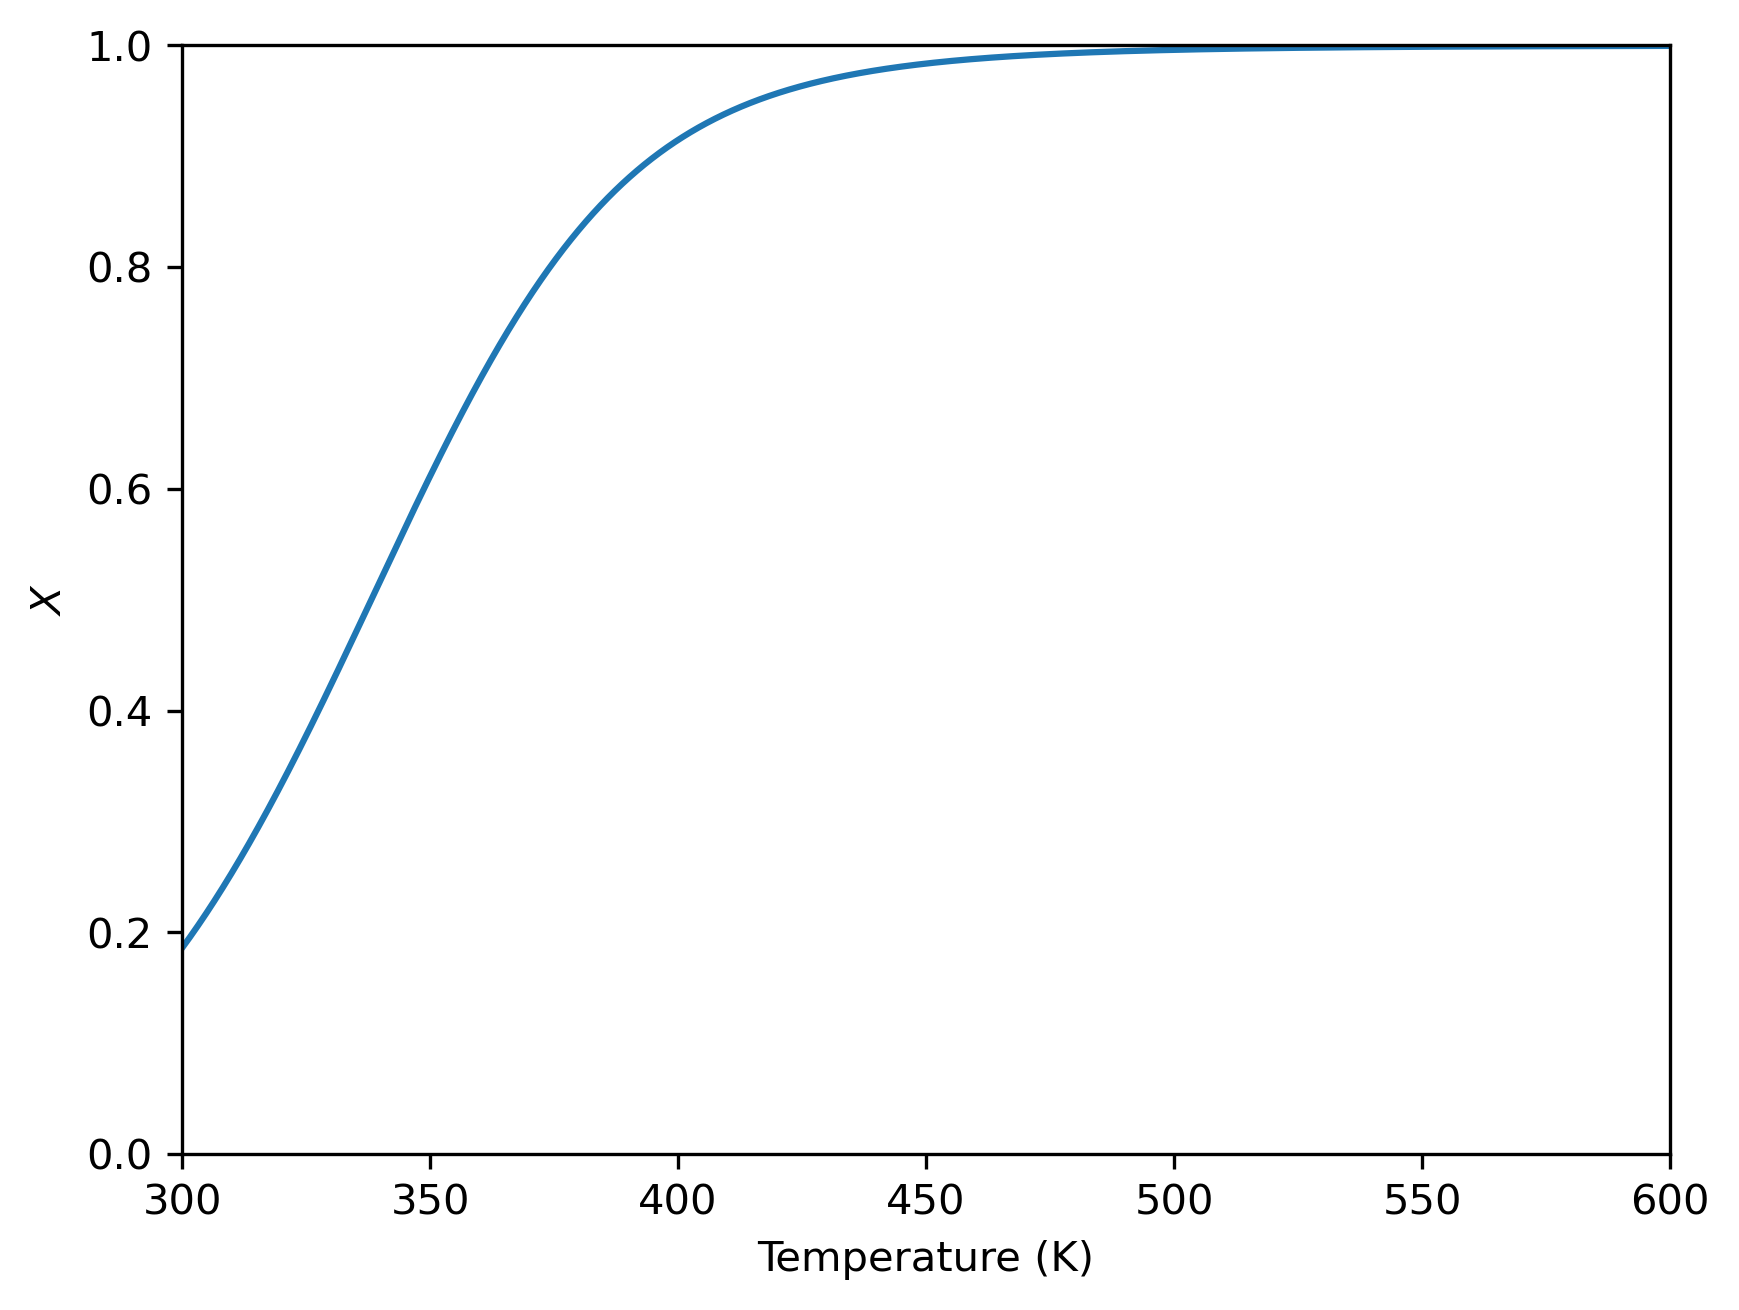

In [4]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(dpi=300)
plt.plot(Ts, Xs)
ax.set(xlabel='Temperature (K)', ylabel='$X$', xlim=(300,600), ylim=(0,1));

now we can numerically find the partial and batta-bing batta-boom find Cv effective

$$
C_{v, \mathrm{eff}} = \sum N_i C_{v,i} + \Delta_\mathrm{rxn} U \left(  \frac{\partial X}{\partial T}  \right)
$$

we also need to relate the internal energy change to the enthalpy change

\begin{align*}
\Delta_\mathrm{rxn} U &= \Delta_\mathrm{rxn} H - \Delta_\mathrm{rxn} PV  \\
&= \Delta_\mathrm{rxn} H - \Delta_\mathrm{rxn} NRT \\
&= \Delta_\mathrm{rxn} H - RT \Delta_\mathrm{rxn} N \\
\end{align*}

and since we know the change in moles per reaction is one

$$
\Delta_\mathrm{rxn} U = \Delta_\mathrm{rxn} H - RT \\
$$


In [5]:
def sum_cv(T, X):
    cv_data = np.array(heat_capacity.loc[components]) 
    cv_data[:,0] = cv_data[:,0] - R # adjust so this is Cv
    params_n2o4, params_no2 = cv_data[0], cv_data[1]

    def calc_cv(coeffs):
        a,b,c,d = coeffs
        return a + b*T + c*T**2 + d*T**3 - R

    N_n2o4 = 1 - X
    N_no2 = 2*X
    return N_n2o4 * calc_cv(params_n2o4) + N_no2 * calc_cv(params_no2)

cveff = sum_cv(Ts, Xs) + (deltaHs - R * Ts) * np.gradient(Xs) / np.gradient(Ts)

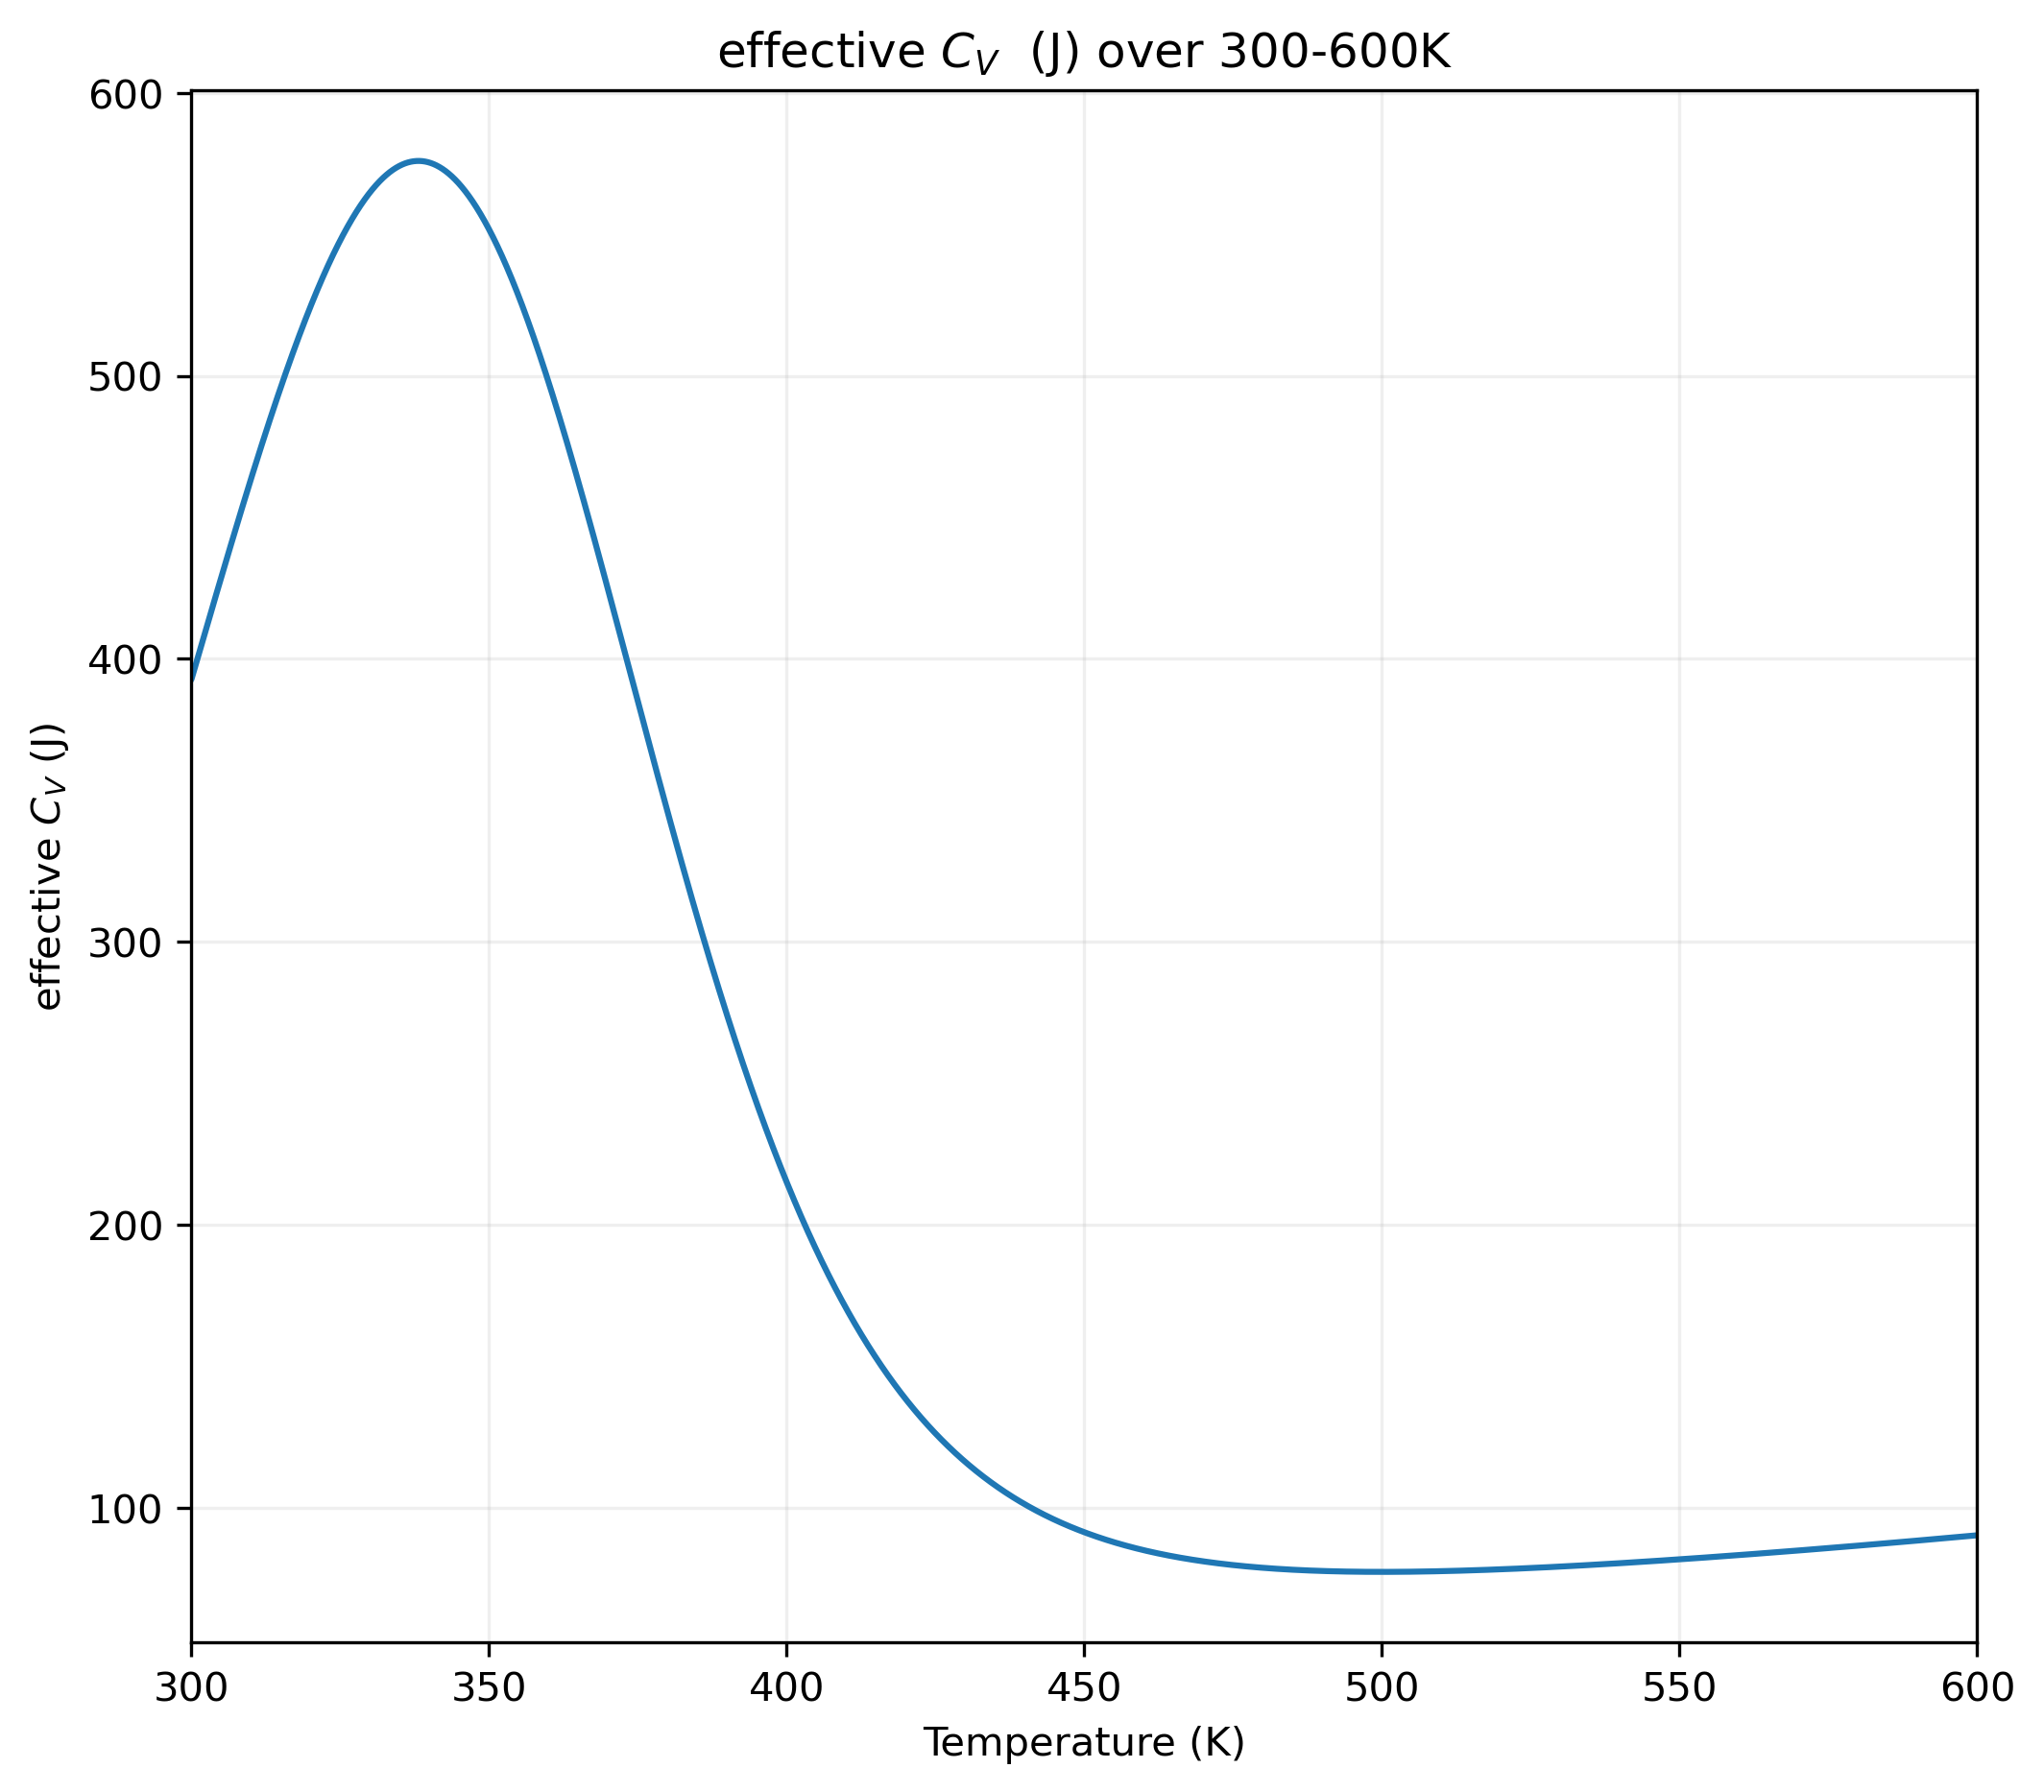

In [6]:
fig,ax = plt.subplots(figsize=(8,7), dpi=300)
ax.plot(Ts, cveff)
ax.grid(alpha=0.2)
ax.set(xlim=(300,600), xlabel='Temperature (K)', ylabel='effective $C_V$ (J)', title='effective $C_V$  (J) over 300-600K');

# if we assume $\Delta_\mathrm{rxn} H$ constant

just out of curiosity, and using the simplified version of the equation provided by the textbook which is mistakenly numbered the same as the other one!

$$
\ln \frac{K_a (T_2)}{K_a (T_1)} = - \frac{\Delta_\mathrm{rxn} H^\circ}{R} \left(   \frac{1}{T_2} - \frac{1}{T_1}  \right) \tag{13.1-22b}
$$

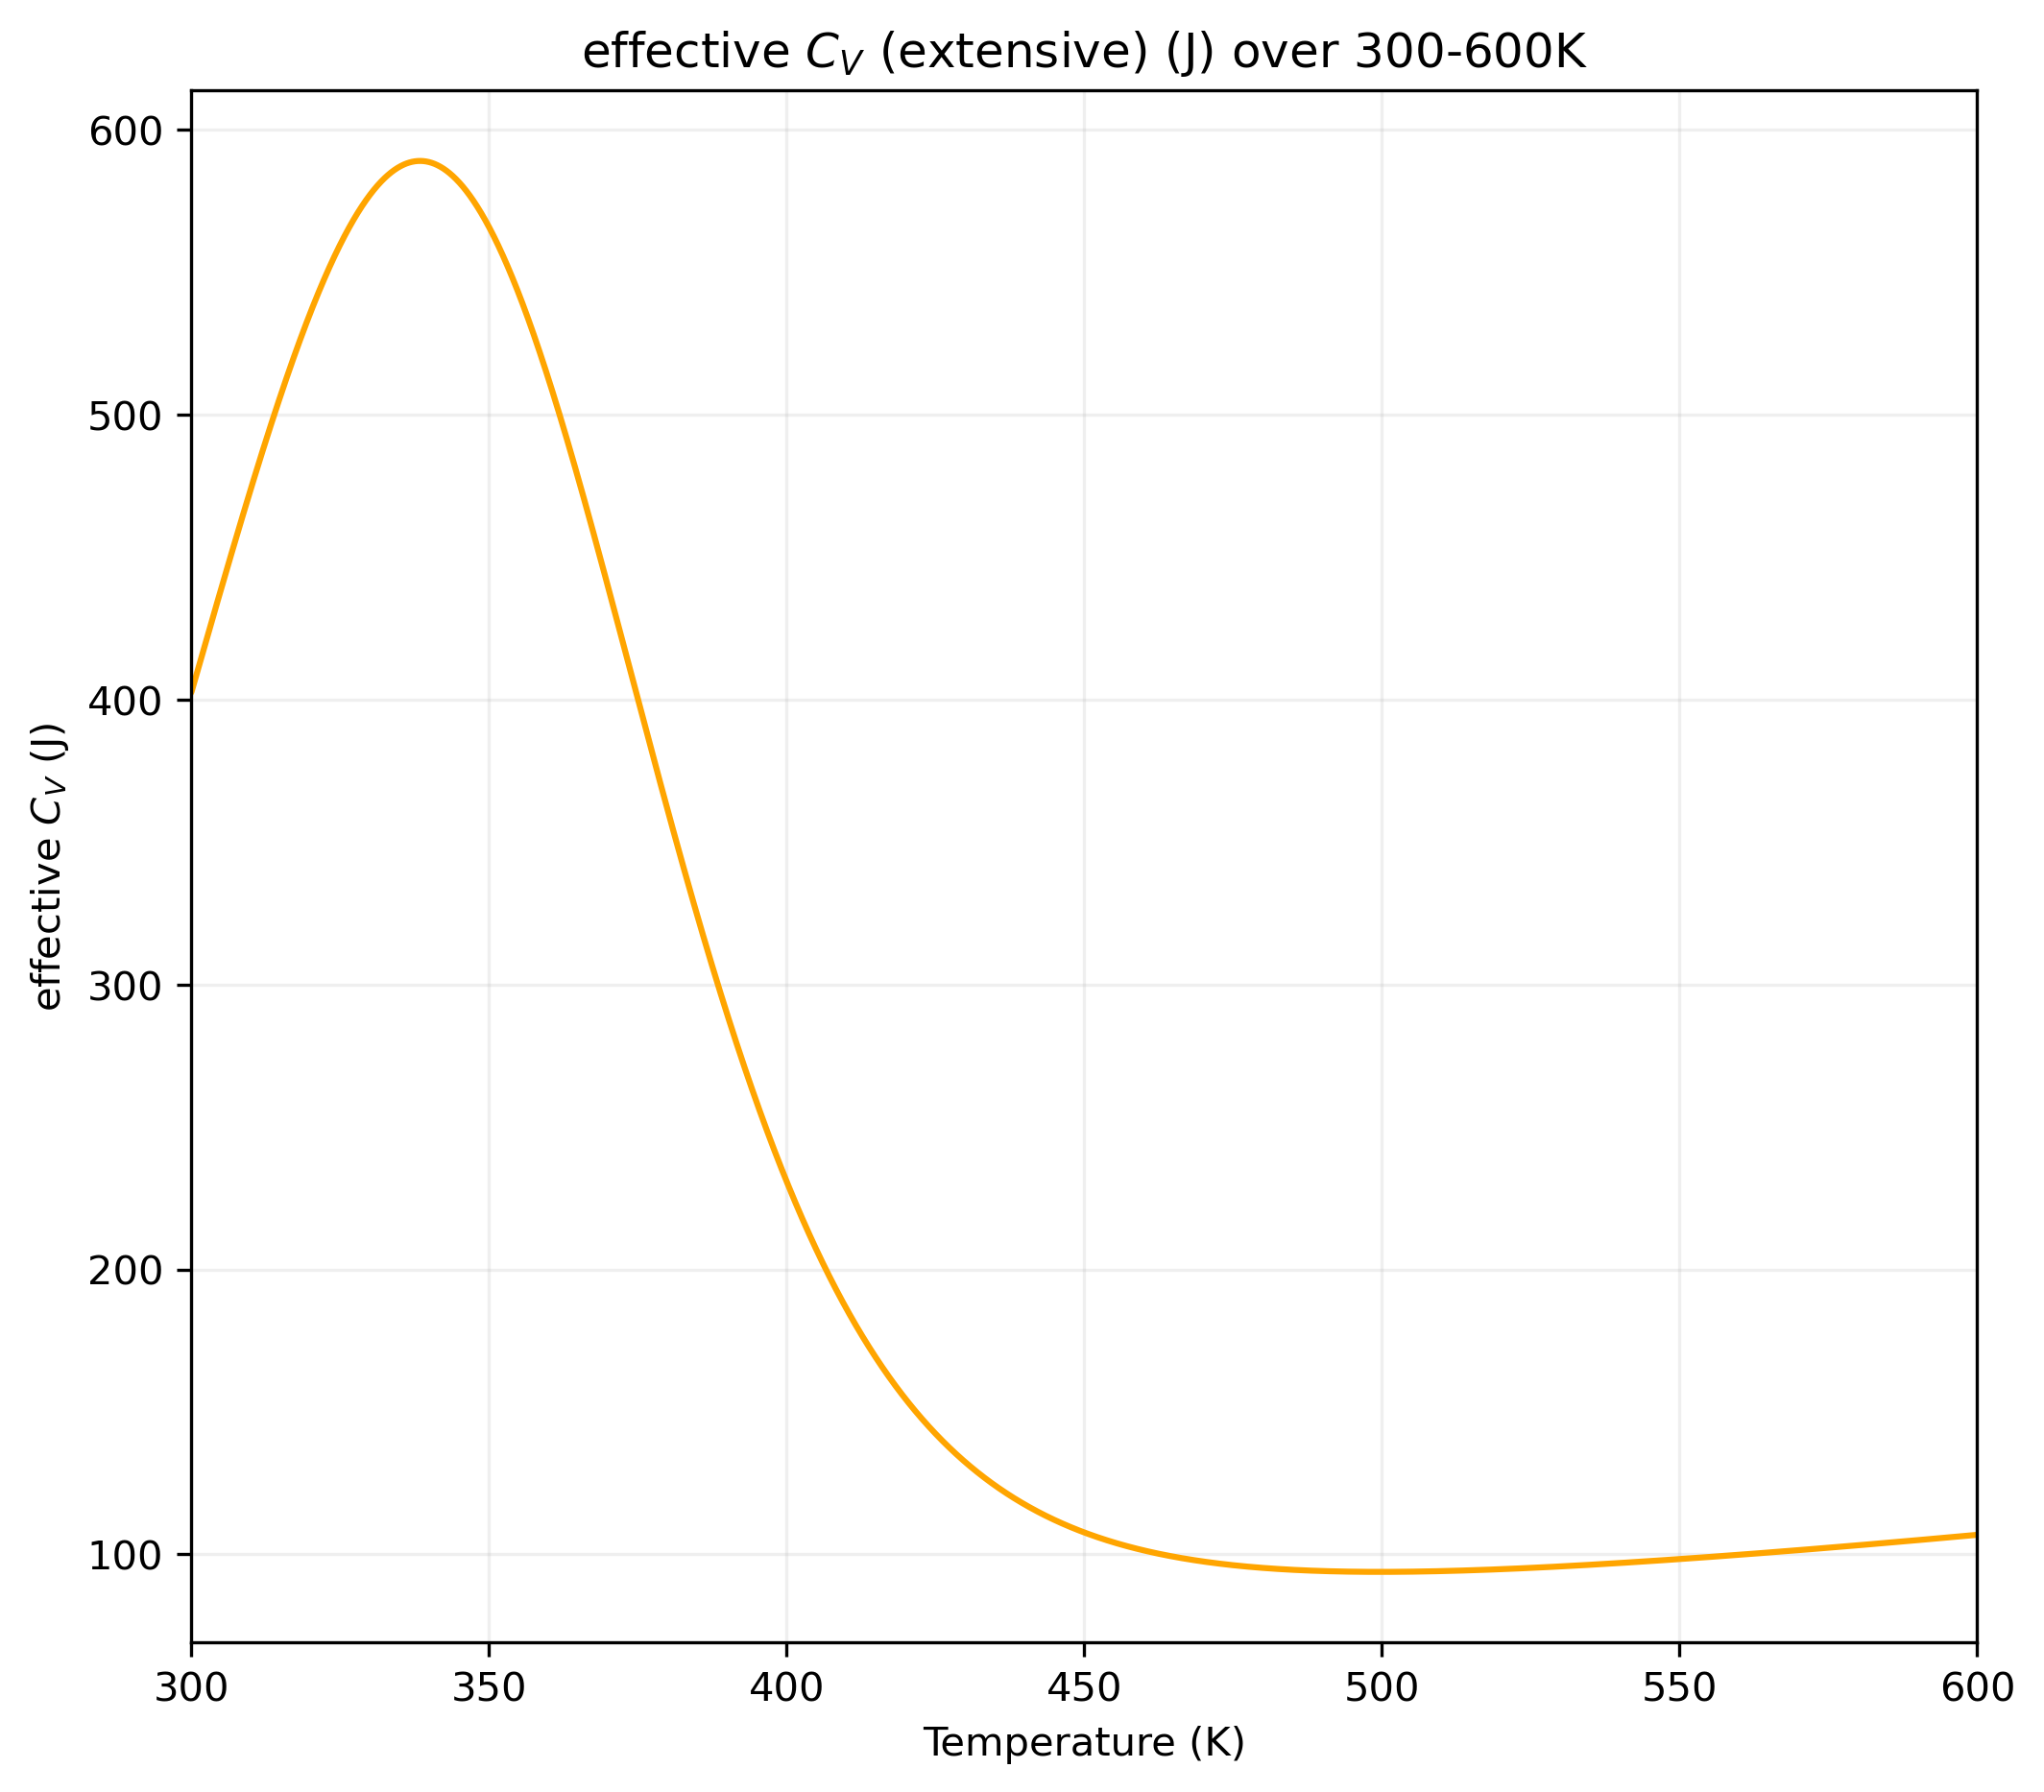

In [7]:
def calcK_andX(T, coeffs=coeffs):
    coeffs = np.array(coeffs)
    
    delta_H = (temp['delta_h_form'].astype(float) * coeffs).sum() * 1000  # J/mol
    delta_G = (temp['delta_g_form'].astype(float) * coeffs).sum() * 1000  # J/mol
    
    K_298 = np.exp(-delta_G / (R * 298.15))
    K_T = K_298 * np.exp(delta_H/R * (1/298.15 - 1/T))

    def solve_for_x(X):
        return np.abs(K_T - 4 * X**2 * T * 1.013 / (1-X) / 298.15)
    X = least_squares(solve_for_x, 0.5, bounds=(0,1), verbose=0).x[0]

    return K_T, X, delta_H

vectorized_calcK_andX = np.vectorize(calcK_andX)
Ts = np.linspace(300,600,10000)
Ks, Xs, deltaHs = vectorized_calcK_andX(Ts)

def sum_cv(T, X):
    cv_data = np.array(heat_capacity.loc[components]) 
    cv_data[:,0] = cv_data[:,0] - R # adjust so this is Cv
    params_n2o4, params_no2 = cv_data[0], cv_data[1]

    def calc_cv(coeffs):
        a,b,c,d = coeffs
        return a + b*T + c*T**2 + d*T**3

    N_n2o4 = 1 - X
    N_no2 = 2*X
    return N_n2o4 * calc_cv(params_n2o4) + N_no2 * calc_cv(params_no2)

cveff = sum_cv(Ts, Xs) + (deltaHs - R * Ts) * np.gradient(Xs) / np.gradient(Ts)

fig, ax = plt.subplots(figsize=(8,7), dpi=300)
ax.plot(Ts, cveff, c='orange')
ax.grid(alpha=0.2)
ax.set(xlim=(300,600), xlabel='Temperature (K)', ylabel='effective $C_V$ (J)', title='effective $C_V$ (extensive) (J) over 300-600K');

without overlaying them i can't tell the difference. seems like this assumption would have been valid

In [8]:
# filler